# Environment_Webcam-GeoCorrection-Yolov4-DeepSort-Velocity_Demo

UNO 2023-03-21 edit

1. 如果沒裝過deep_sort_realtime，pip裝一下，裝過了就忽略就好
2. 接上非魚眼的webcame，在相機視野中間的地板上以「鮮豔的膠帶」貼大正方形，讓程式碼可以做幾何矯正
3. 用Geometery Correction，取得矯正矩陣M
4. 用02人物偵測開始測量人流量與速度，可以調整fps

-----

- 還需要有人改寫成.py檔，做成文字對話或是GUI
- 還需要有人訂下輸出規格
    - 怎麼傳輸給其他程式?
    - 要輸出那些資訊?現在可以每個人的ID、位置、速率、所有人的平均速率、總人數等等

In [ ]:
pip install deep_sort_realtime

# 01 Geometery Correction

### cap = cv2.VideoCapture(0) 後面的數字是相機編號，選擇對的編號

重點是最後產生的M矩陣

(只是用非魚眼的CASE)

到時候的作法是先在地板貼個正方形膠帶，然後給機器自己抓

若不更動「攝影機角度」，只要第一次使用時校正就可以

這裡用別人的圖片+拿小畫家畫個長方形假裝是膠帶來示意

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cap = cv2.VideoCapture(0) #選擇編號

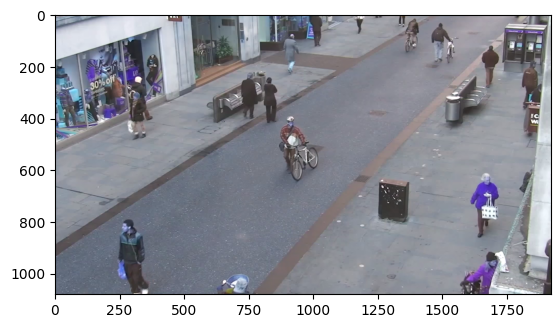

In [7]:
import time

time.sleep(3) #倒數三秒

ret, img = cap.read() #拍一張照片
plt.imshow(img)
plt.show()

### 如果膠帶不夠鮮豔，可以調整下列這個函數的參數來進行更好的幾何矯正辨識。

lines = cv2.HoughLinesP(image, rho, theta, threshold, min, max)
- image	8-bit, single-channel binary source image. The image may be modified by the function.
- lines	Output vector of lines. Each line is represented by a 4-element vector (x1,y1,x2,y2) , where (x1,y1) and (x2,y2) are the ending points of each detected line segment.
- rho	Distance resolution of the accumulator in pixels.
- theta	Angle resolution of the accumulator in radians.
- threshold	Accumulator threshold parameter. Only those lines are returned that get enough votes ( >threshold ).
- minLineLength	Minimum line length. Line segments shorter than that are rejected.
- maxLineGap	Maximum allowed gap between points on the same line to link them.


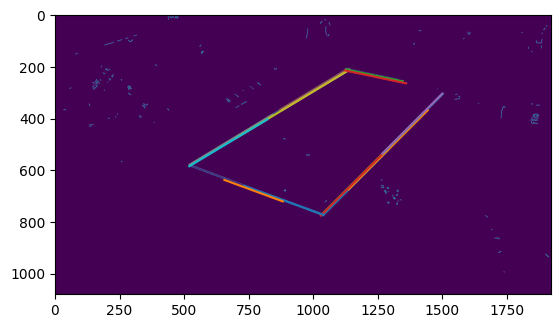

[-0.78539816 -0.78539816 -2.44776056 -1.25903482]
[array([ 514.54295189, 1129.71155427, 1039.2673031 , 1519.68421053]), array([580.30231469, 209.77605226, 771.7326969 , 291.31578947])]


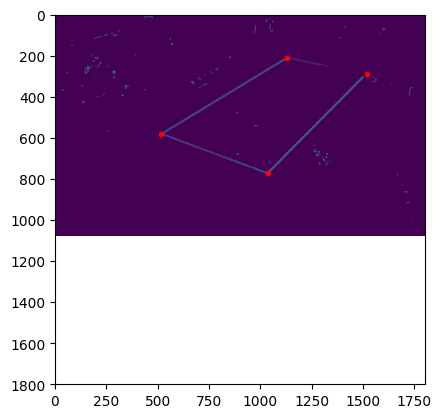

幾何矯正矩陣 =  [[ 2.39153472e-01 -1.29174859e-01  5.67401684e+02]
 [ 8.40772596e-01  1.96335253e+00 -9.56455677e+02]
 [-3.11214523e-05  1.83984540e-03  1.00000000e+00]]


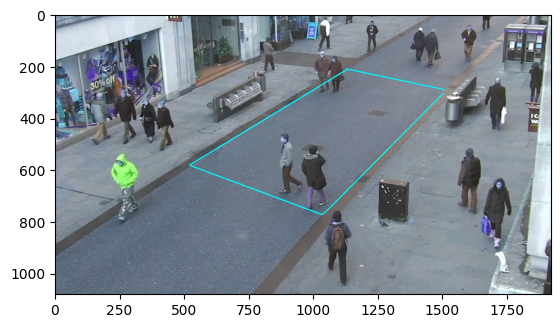

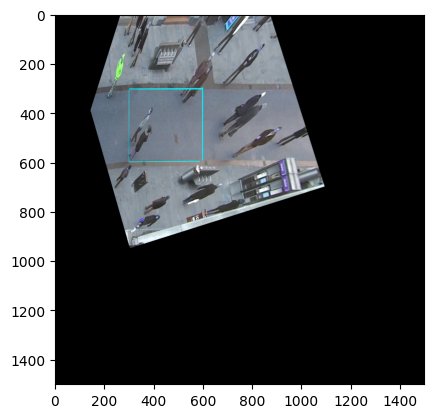

In [11]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find edges
edges = cv2.Canny(img, 500, 600)

# find lines
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 60, minLineLength=220, maxLineGap=100)
for i in range(len(lines)):
    plt.plot([np.array(lines)[i][0][0],np.array(lines)[i][0][2]],[np.array(lines)[i][0][1],np.array(lines)[i][0][3]])
plt.imshow(edges)
plt.show()

intersections = []
for i in range(len(lines)):
    for j in range(i+1, len(lines)):
        x1, y1, x2, y2 = lines[i][0]
        x3, y3, x4, y4 = lines[j][0]
        
        m = (y1-y2)/(x1-x2)
        n = (y3-y4)/(x3-x4)
        a = y1 - m*x1
        b = y3 - n*x3
        
        if abs(m*n) < 0.4 and  abs(m-n)>0.01:
            px = (b-a)/(m-n)
            py = m*px + a
            if px >0 and py > 0:
                intersections.append([px, py])


# remove duplicates
threshold = 100 
data = np.array(intersections)

# 建立一個空的布林遮罩
mask = []

# 比較每兩個項是否相近，如果是就將遮罩設為True

for i in range(len(data)):
    for j in range(i+1, len(data)):
        if abs(data[i][0] - data[j][0]) + abs(data[i][1] - data[j][1]) < threshold:
            mask.append(j)

# 使用np.delete()函數刪除遮罩為True的項
intersections = [np.delete(data.T[0], mask) ,np.delete(data.T[1], mask)]

# # sort intersections by clockwise order
center = np.mean(intersections, axis=0)
angles = np.arctan2(intersections[1] - center[1], intersections[0] - center[0])
print(angles)
indices = np.argsort(angles)
intersections[0] = intersections[0][indices]
intersections[1] = intersections[1][indices]


# Display the image
plt.imshow(edges)
plt.plot(intersections[0],intersections[1],'r.')
print(intersections)
plt.xlim([0,1800])
plt.ylim([1800,0])
plt.show()


# get perspective transform matrix
pts1 = np.float32(np.array(intersections).T)
pts2 = np.float32([[300, 300], [600, 300],[300, 600],[600, 600]])
M = cv2.getPerspectiveTransform(pts1, pts2) #之後都會用他
print('幾何矯正矩陣 = ', M)


# warp perspective
dst = cv2.warpPerspective(img, M, (1500, 1500))

# show result
plt.imshow(img)
plt.show()
plt.imshow(dst)
plt.show()


# 02 以webcam 人物偵測

In [13]:
import cv2
import numpy as np
import time
from deep_sort_realtime.deepsort_tracker import DeepSort
import datetime


config_file = 'yolov4.cfg'
weights_file = 'yolov4.weights'

net = cv2.dnn.readNetFromDarknet(config_file, weights_file)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

deepsort = DeepSort()

def process_image(image):
    blob = cv2.dnn.blobFromImage(image, 1/255, (416, 416), [0, 0, 0], 1, crop=False)
    net.setInput(blob)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]
    detections = net.forward(output_layers)

    height, width, _ = image.shape
    threshold = 50
    person_detections = []
    person_detections_input = []
    
    for detection in detections[0]:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5 and class_id == 0:
            center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')
            x1 = center_x
            y1 = center_y + h / 2
            mask = 0
            for i in range(len(person_detections)):
                if abs(x1 - person_detections[i][0]) + abs(y1 - person_detections[i][1]) < threshold:
                    mask = 1
                
            if mask == 0:
                person_detections.append([x1, y1])
                person_detections_input.append([[x1 - w/2, y1-h, w, h], confidence])

    embed = deepsort.generate_embeds(image, person_detections_input)
    det = deepsort.create_detections(person_detections_input, embed)
    raw_detections = [[detection.to_tlbr().tolist(),detection.confidence,detection.class_name] for detection in det]

    People_list = deepsort.update_tracks(raw_detections, embed)
    return People_list



# 使用 Webcam 進行影像捕捉
cap = cv2.VideoCapture(0)

print('webcam ok',cap)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# 如果不要特別錄影
output_video_path = 'output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (width, height))

frame_count = 0
previous_locations = {}
speeds = {}

fps = 5
k = 10 #幾張照片平均算一次速度~ k = 走路的週期(1s)*fps

while True:
    total_people_count = 0
    total_speed_sum = 0
    
    ret, image = cap.read()
    
    target_time = datetime.datetime.now() + datetime.timedelta(seconds=1/fps) # 10 
    
    if not ret:
        break
    if frame_count < k+1:
        print('initialize %d %%' %(100/(k+1)*(frame_count)))
    else:
        print('--------- %05d ---------' %(frame_count-k))
        
    #開始處理影像
    People_list = process_image(image)

    if People_list == []:
        print('no people detection')
    
    
    for people in People_list:
        
        try:
        
            x1, y1, x2, y2 = people.original_ltwh
            bottom_x, bottom_y = (x1+x2)/2, y2

            # 進行幾何矯正
            x, y, z = M.dot(([bottom_x,bottom_y,1]))
            bottom_x = x/z
            bottom_y = y/z

            track_id = people.track_id

            if track_id not in previous_locations:
                previous_locations[track_id] = []
                previous_locations[track_id].append([bottom_x, bottom_y])
            
            else:
                
                if len(previous_locations[track_id]) > k:
                    length = np.sqrt((bottom_x - previous_locations[track_id][-k][0])**2 + (bottom_y - previous_locations[track_id][-k][1])**2)
                    avg_speed = length/k*fps # abitrary length/sec
                    
                    # save speed
                    if track_id not in speeds:
                        speeds[track_id] = []
                    speeds[track_id].append(avg_speed)
                    
                    print(f"ID {track_id} speed：{avg_speed:.2f}")
                previous_locations[track_id].append((bottom_x, bottom_y))  
                
                total_speed_sum += avg_speed
            total_people_count += 1
        except Exception as e:
            1
        #print( bottom_x, bottom_y,people.track_id)
    
    frame_count += 1
    

    # 繪製邊界框、ID 和速度
    for people in People_list:
        try:
            x1, y1, x2, y2 = people.original_ltwh
            cv2.rectangle(image, tuple([np.int16(x1), np.int16(y1)]), tuple([np.int16(x2), np.int16(y2)]), (0, 255, 0), 2)
            track_id = people.track_id

            speed = speeds[track_id][-1] if track_id in speeds else 0  
            cv2.putText(image, f"ID: {track_id}, Speed: {speed:.2f}", tuple([np.int16(x1), np.int16(y1) - 10]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        except Exception as e:
            1

    # 在右上角顯示總人數和平均速度
    avg_speed = total_speed_sum / total_people_count if total_people_count > 0 else 0
    print(f"Total People: {total_people_count}, Avg Speed: {avg_speed:.2f}")
    cv2.putText(image, f"Total People: {total_people_count}, Avg Speed: {avg_speed:.2f}", tuple([width - 600, 30]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)


    # 將帶有邊界框的圖像寫入影片輸出文件
    out.write(image)
    
    
    while datetime.datetime.now() < target_time:
        time.sleep(0.01) # Sleep for 0.1 seconds
    

    
cap.release()
out.release() # 釋放 VideoWriter 資源
cv2.destroyAllWindows()

webcam ok < cv2.VideoCapture 0000029D207CF8D0>
initialize 0 %
initialize 9 %
initialize 18 %
initialize 27 %
initialize 36 %
initialize 45 %
有人怪怪的
有人怪怪的
initialize 54 %
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
initialize 63 %
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
initialize 72 %
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
initialize 81 %
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
initialize 90 %
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00001 ---------
ID 1 speed：1.86
有人怪怪的
有人怪怪的
ID 4 speed：11.01
ID 5 speed：8.01
ID 6 speed：10.15
有人怪怪的
ID 8 speed：4.67
ID 9 speed：5.37
有人怪怪的
ID 11 speed：10.72
ID 12 speed：5.15
ID 13 speed：6.62
有人怪怪的
ID 15 speed：5.55
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00002 ---------
ID 1 speed：2.78
有人怪怪的
有人怪怪的
ID 4 speed：9.72
ID 5 speed：9.18
ID 6 speed：10.16
有人怪怪的
ID 8 speed：4.36
ID 9 speed：5.29
有人怪怪的
ID 11 speed：12.00
ID 12 speed：5.47
ID 13 speed：8.99
有人怪怪的
ID 15 speed：6.19
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00003 ---------
ID 1 speed：2.78
有人怪怪的
有人怪怪的
ID 4 speed：9.41
ID 5 speed：9

ID 1 speed：4.70
有人怪怪的
ID 5 speed：4.99
ID 6 speed：8.67
有人怪怪的
ID 8 speed：7.62
ID 9 speed：6.41
ID 10 speed：8.03
ID 11 speed：10.73
ID 12 speed：3.29
ID 13 speed：12.05
有人怪怪的
ID 15 speed：5.60
有人怪怪的
ID 17 speed：6.86
ID 20 speed：4.66
ID 23 speed：5.90
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00029 ---------
ID 1 speed：4.97
有人怪怪的
ID 5 speed：4.71
ID 6 speed：7.87
有人怪怪的
ID 8 speed：9.12
ID 9 speed：6.06
ID 10 speed：7.80
ID 11 speed：5.95
ID 12 speed：2.92
ID 13 speed：10.84
有人怪怪的
ID 15 speed：5.08
有人怪怪的
ID 17 speed：7.08
ID 20 speed：4.71
ID 23 speed：7.25
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00030 ---------
ID 1 speed：5.16
有人怪怪的
ID 5 speed：3.75
ID 6 speed：7.03
有人怪怪的
ID 8 speed：9.90
ID 9 speed：5.23
ID 10 speed：9.64
ID 11 speed：6.20
ID 12 speed：4.46
ID 13 speed：11.45
ID 15 speed：4.27
有人怪怪的
ID 17 speed：7.24
ID 20 speed：5.25
ID 23 speed：6.38
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00031 ---------
ID 1 speed：7.05
有人怪怪的
ID 5 speed：4.29
ID 6 speed：5.96
有人怪怪的
ID 8 speed：5.14
ID 9 speed：6.67
ID 10 spee

ID 1 speed：5.90
ID 5 speed：3.71
ID 6 speed：7.67
ID 8 speed：8.23
ID 9 speed：6.11
有人怪怪的
ID 11 speed：6.70
有人怪怪的
有人怪怪的
ID 15 speed：7.20
ID 17 speed：5.73
ID 20 speed：3.95
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00059 ---------
ID 1 speed：4.93
ID 5 speed：3.08
ID 6 speed：1.19
ID 8 speed：8.64
ID 9 speed：4.82
有人怪怪的
ID 11 speed：6.21
有人怪怪的
有人怪怪的
ID 15 speed：6.39
ID 17 speed：4.77
ID 20 speed：3.95
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00060 ---------
ID 1 speed：5.29
ID 5 speed：4.69
ID 6 speed：1.26
ID 8 speed：6.62
ID 9 speed：5.06
有人怪怪的
ID 11 speed：11.19
ID 12 speed：3.49
有人怪怪的
ID 15 speed：5.74
ID 17 speed：5.54
ID 20 speed：4.54
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00061 ---------
ID 1 speed：5.53
有人怪怪的
ID 6 speed：1.80
ID 8 speed：5.56
ID 9 speed：4.97
有人怪怪的
ID 11 speed：15.32
ID 12 speed：3.81
有人怪怪的
ID 15 speed：6.28
ID 17 speed：6.53
ID 20 speed：4.33
有人怪怪的
有人怪怪的
有人怪怪

--------- 00092 ---------
有人怪怪的
ID 5 speed：5.61
ID 6 speed：2.12
ID 8 speed：5.64
ID 9 speed：4.61
ID 11 speed：9.26
ID 12 speed：1.81
ID 15 speed：8.85
有人怪怪的
有人怪怪的
有人怪怪的
ID 38 speed：3.98
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00093 ---------
有人怪怪的
ID 5 speed：6.11
ID 6 speed：4.89
ID 8 speed：5.34
ID 9 speed：5.17
ID 11 speed：9.87
ID 12 speed：1.50
ID 15 speed：7.90
有人怪怪的
有人怪怪的
有人怪怪的
ID 38 speed：3.01
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00094 ---------
有人怪怪的
ID 5 speed：8.21
ID 6 speed：6.11
ID 8 speed：5.58
ID 9 speed：5.26
ID 11 speed：11.57
ID 12 speed：2.00
ID 15 speed：5.02
有人怪怪的
有人怪怪的
有人怪怪的
ID 38 speed：6.02
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00095 ---------
有人怪怪的
ID 5 speed：3.36
ID 6 speed：6.42
ID 8 speed：4.85
ID 9 speed：4.42
ID 11 speed：8.50
ID 12 speed：1.69
ID 15 speed：4.95
有人怪怪的
有人怪怪的
有人怪怪的
ID 38 speed：5.92
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00096 ---------
有人怪怪的
ID 5 speed：5.00
ID 6 speed：4.62
ID 8 speed：4.32
ID 9 speed：5.95
ID 11 speed：6.72
ID 12 speed：1.59
ID 15 speed：4.85
有人怪怪的
有人怪怪的
有人怪怪的
ID 38 spee

有人怪怪的
有人怪怪的
ID 8 speed：8.07
ID 9 speed：9.20
ID 11 speed：8.16
有人怪怪的
ID 15 speed：3.80
ID 38 speed：5.49
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
ID 45 speed：1.46
ID 46 speed：7.34
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00136 ---------
有人怪怪的
ID 8 speed：8.02
ID 9 speed：7.98
ID 11 speed：9.23
有人怪怪的
ID 15 speed：3.18
ID 38 speed：7.71
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
ID 45 speed：1.46
ID 46 speed：5.47
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00137 ---------
有人怪怪的
ID 8 speed：6.61
ID 9 speed：8.13
ID 11 speed：7.08
有人怪怪的
ID 15 speed：3.02
ID 38 speed：7.31
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
ID 45 speed：1.56
ID 46 speed：4.75
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00138 ---------
有人怪怪的
ID 8 speed：7.98
ID 9 speed：6.38
ID 11 speed：10.37
有人怪怪的
ID 15 speed：3.21
ID 38 speed：5.41
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
ID 46 speed：4.50
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00139 ---------
ID 8 speed：6.91
ID 9 speed：7.44
ID 11 speed：10.68
有人怪怪的
ID 15 speed：6.31
ID 38 speed：5.93
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
ID 46 speed：4.72
有

--------- 00175 ---------
ID 8 speed：5.73
ID 9 speed：3.69
ID 11 speed：11.64
ID 15 speed：5.80
ID 38 speed：6.61
ID 46 speed：6.02
ID 49 speed：5.03
ID 51 speed：13.83
ID 53 speed：10.16
有人怪怪的
有人怪怪的
ID 58 speed：5.95
ID 59 speed：9.56
有人怪怪的
有人怪怪的
--------- 00176 ---------
ID 8 speed：5.01
ID 9 speed：3.69
ID 11 speed：11.48
ID 15 speed：4.85
ID 38 speed：5.51
ID 46 speed：8.78
ID 49 speed：4.48
ID 51 speed：13.04
ID 53 speed：7.07
有人怪怪的
有人怪怪的
ID 58 speed：6.58
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00177 ---------
ID 8 speed：5.53
ID 9 speed：4.39
有人怪怪的
ID 15 speed：5.66
ID 38 speed：7.66
ID 46 speed：7.47
ID 49 speed：4.91
ID 51 speed：10.71
ID 53 speed：13.10
有人怪怪的
有人怪怪的
ID 58 speed：7.40
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00178 ---------
ID 8 speed：5.40
ID 9 speed：4.72
有人怪怪的
ID 15 speed：5.40
ID 38 speed：8.52
ID 46 speed：5.44
ID 49 speed：5.41
ID 51 speed：9.19
ID 53 speed：10.29
有人怪怪的
有人怪怪的
ID 58 speed：7.77
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00179 ---------
ID 8 speed：4.30
ID 9 speed：5.11
有人怪怪的
ID 15 speed：4

ID 8 speed：7.25
ID 9 speed：7.40
ID 15 speed：13.86
ID 38 speed：8.95
ID 46 speed：6.82
ID 49 speed：5.42
有人怪怪的
有人怪怪的
ID 64 speed：1.10
有人怪怪的
有人怪怪的
--------- 00214 ---------
ID 8 speed：7.35
ID 9 speed：5.86
ID 15 speed：15.71
ID 38 speed：8.85
ID 46 speed：7.28
ID 49 speed：5.95
有人怪怪的
有人怪怪的
ID 64 speed：1.46
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00215 ---------
ID 8 speed：5.13
ID 9 speed：4.27
ID 15 speed：9.49
ID 38 speed：7.16
ID 46 speed：6.55
ID 49 speed：5.45
有人怪怪的
有人怪怪的
ID 64 speed：1.07
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00216 ---------
ID 8 speed：3.89
ID 9 speed：7.86
ID 15 speed：14.16
ID 38 speed：8.03
ID 46 speed：6.70
ID 49 speed：5.31
有人怪怪的
有人怪怪的
ID 64 speed：0.84
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00217 ---------
ID 8 speed：4.01
ID 9 speed：8.49
ID 15 speed：7.74
ID 38 speed：8.04
ID 46 speed：6.25
ID 49 speed：5.31
有人怪怪的
有人怪怪的
ID 64 speed：0.23
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00218 ---------
ID 8 speed：4.65
ID 9 speed：5.01
ID 15 speed：8.37
ID 38 speed：3.78
ID 46 speed：8.30
ID 49 speed：4.93
有人怪怪的
有人怪怪的
ID

ID 8 speed：7.26
ID 9 speed：4.65
ID 15 speed：6.28
ID 38 speed：3.92
ID 46 speed：8.18
ID 49 speed：7.19
ID 64 speed：1.76
ID 68 speed：2.33
ID 72 speed：7.82
有人怪怪的
有人怪怪的
--------- 00256 ---------
ID 8 speed：9.12
ID 9 speed：3.61
ID 15 speed：6.73
ID 38 speed：2.67
ID 46 speed：6.25
ID 49 speed：7.53
ID 64 speed：2.19
ID 68 speed：2.20
ID 72 speed：7.20
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00257 ---------
ID 8 speed：11.18
ID 9 speed：3.64
ID 15 speed：6.16
ID 38 speed：2.67
ID 46 speed：5.80
ID 49 speed：3.93
ID 64 speed：1.94
ID 68 speed：2.06
ID 72 speed：6.19
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00258 ---------
ID 8 speed：8.36
ID 9 speed：5.64
ID 15 speed：5.70
ID 38 speed：1.88
ID 46 speed：7.53
ID 49 speed：4.67
ID 64 speed：2.11
ID 68 speed：1.61
ID 72 speed：6.23
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00259 ---------
ID 8 speed：8.67
ID 9 speed：5.06
ID 15 speed：4.98
ID 38 speed：1.53
ID 46 speed：9.54
ID 49 speed：3.71
ID 64 speed：2.34
ID 68 speed：2.01
ID 72 speed：9.07
有人怪怪的
有人怪怪的
有人怪怪的
有人怪怪的
--------- 00260 ---------
ID 8 s